In [1]:
import os 
import numpy as np 
import torch 
import torch.nn as nn
import torch.functional as F
import unicodedata
import re
from sklearn.model_selection import train_test_split 

# 流程说明 

使用pytorch自带transformer 实现机器学习的demo。参考 https://blog.csdn.net/u010366748/article/details/111269231

**后续改进的方向**

- 实现中英翻译（感受下翻译质量）
- 更大的数据集（让模型有点用处）
- 手动实现transformer架构（了解transformer里面的坑）

## 数据预处理

- 将数据划分为 英语数据，法语数据
- 全部转为小写， 标点符号需要和单词分开
- 分词处理，单个单词作为一个分词， 构建词表

In [24]:
data_path = 'data/data/eng-fra.txt'

en_data = []
fra_data = []
with open(data_path, mode = 'r', encoding = 'UTF-8') as f:
    count = 0
    for line in f:
        count += 1
        en, fra = line.strip().split('\t') 
        en_data.append(en.lower())
        fra_data.append(fra.lower())
f.close()
print(count)

135842


In [29]:
import unicodedata
import re
# 数据预处理

# 将unicode字符串转化为ASCII码：
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')


# 规范化字符串
def normalizeString(s):
    # print(s) # list  ['Go.']
    # s = s[0]
    s = s.lower().strip()
    s = unicodeToAscii(s)
    s = re.sub(r"([.!?])", r" \1", s)  # \1表示group(1)即第一个匹配到的 即匹配到'.'或者'!'或者'?'后，一律替换成'空格.'或者'空格!'或者'空格？' ## word! --> word !
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)  # 非字母以及非.!?的其他任何字符 一律被替换成空格
    s = re.sub(r'[\s]+', " ", s)  # 将出现的多个空格，都使用一个空格代替。例如：w='abc  1   23  1' 处理后：w='abc 1 23 1'
    return s

for i,sentence in enumerate(en_data):
    en_data[i] = normalizeString(sentence)

for i,sentence in enumerate(fra_data):
    fra_data[i] = normalizeString(sentence)


In [45]:
### 以单词为单位构建分词器

class tokenizer:
    def __init__(self, token2id_dic, id2token_dic):
        self.token2id_dic = token2id_dic
        self.id2token_dic = id2token_dic
        self.vocab_size = len(token2id_dic)

    def str2id(self, sentence):
        # sentence to token id_list:
        id_list = []
        for token in sentence:
            if token in self.token2id_dic:
                id_list.append(self.token2id_dic[token])
            else:
                id_list.append(self.token2id_dic['<unk>'])
        return id_list
    
    def id2str(self, id_list):
        sentence = []
        for idx in id_list:
            sentence.append(self.id2token_dic[idx])
        return sentence
            

In [53]:
## 构建词典

def get_token_count(sentence_list):
    # sentence_list: list of sentence
    # return token count dict

    token_count = {}
    for sentence in sentence_list:
        word_list = sentence.split(' ')
        for word in word_list:
            if word in token_count:
                token_count[word] += 1
            else:
                token_count[word] = 1
    
    sorted_dict = dict(sorted(token_count.items(), key=lambda x: x[1], reverse=True))
    return sorted_dict

def get_token2id_dic(sorted_dict, k):
    # return top k element in a sorted_dict

    sel_dic = dict(list(sorted_dict.items())[:min(k,len(sorted_dict))])
    special_token = ['<cls>','<qed>', '<pad>', '<unk>'] # 开始， 终止， 填充， 未知
    token2id_dic = {}
    for i,ele in enumerate(special_token):
        token2id_dic[ele] = i 
    
    for i, key in enumerate(list(sel_dic.keys())):
        token2id_dic[key] = 4+i
  
    return token2id_dic

def get_id2token_dic(token2id_dic):
    id2token_dic = {}
    for key,value in token2id_dic.items():
        id2token_dic[value] = key 
    return id2token_dic 

def get_dic(sentence_list,k):
    sorted_dict = get_token_count(sentence_list)
    print(f"original token num is {len(sorted_dict)}")
    token2id_dic = get_token2id_dic(sorted_dict, k)
    print(f"actural token num is {len(token2id_dic)}")
    id2token_dic = get_id2token_dic(token2id_dic)
    return token2id_dic, id2token_dic
        

In [55]:
en_token2id, en_id2token = get_dic(en_data,10000)
fra_token2id, fra_id2token = get_dic(fra_data,18000)

original token num is 13041
actural token num is 10004
original token num is 21332
actural token num is 18004


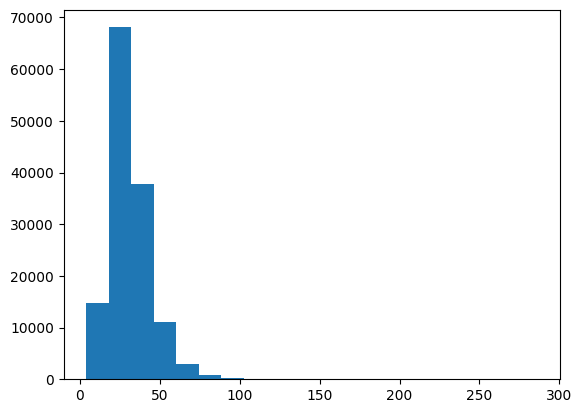

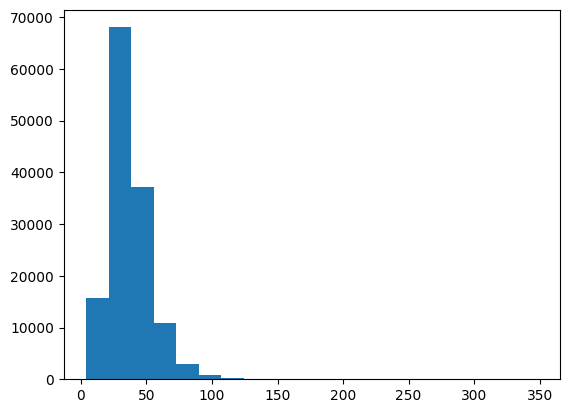

In [89]:
import matplotlib.pyplot as plt 
en_l = []
for _ in en_data:
    en_l.append(len(_))
en_l = np.array(en_l)
plt.hist(en_l, bins = 20)
plt.show()
fra_l = []
for _ in fra_data:
    fra_l.append(len(_))
fra_l = np.array(fra_l)
plt.hist(fra_l, bins = 20)
plt.show()

In [57]:
### 构建 分词器 
en_tokenizer = tokenizer(token2id_dic= en_token2id, id2token_dic= en_id2token)
fra_tokenizer = tokenizer(token2id_dic= fra_token2id, id2token_dic= fra_id2token)

In [63]:
### 划分训练集与测试集

n = len(en_data)

train_id, test_id = train_test_split(np.arange(n), train_size = 0.8)

en_train = []
en_test = []
fra_train = []
fra_test = []

for idx in train_id:
    en_train.append(en_data[idx])
    fra_train.append(fra_data[idx])

for idx in test_id:
    en_test.append(en_data[idx])
    fra_test.append(fra_data[idx])

In [72]:
max_l = 0 
for _ in en_data:
    max_l = max(max_l, len(_))
print(max_l)

286


In [69]:
en_tokenizer.str2id(en_train[0])

[3, 4252, 3, 4252, 10, 11, 3, 4837, 5, 16, 8379, 3, 7117, 10, 3, 3, 4]

['go .',
 'run !',
 'run !',
 'wow !',
 'fire !',
 'help !',
 'jump .',
 'stop !',
 'stop !',
 'stop !',
 'wait !',
 'wait !',
 'i see .',
 'i try .',
 'i won !',
 'i won !',
 'oh no !',
 'attack !',
 'attack !',
 'cheers !',
 'cheers !',
 'cheers !',
 'get up .',
 'got it !',
 'got it !',
 'got it ?',
 'got it ?',
 'got it ?',
 'hop in .',
 'hop in .',
 'hug me .',
 'hug me .',
 'i fell .',
 'i fell .',
 'i know .',
 'i left .',
 'i left .',
 'i lost .',
 'i m .',
 'i m ok .',
 'i m ok .',
 'listen .',
 'no way !',
 'no way !',
 'no way !',
 'no way !',
 'no way !',
 'no way !',
 'no way !',
 'really ?',
 'really ?',
 'really ?',
 'thanks .',
 'we try .',
 'we won .',
 'we won .',
 'we won .',
 'we won .',
 'ask tom .',
 'awesome !',
 'be calm .',
 'be calm .',
 'be calm .',
 'be cool .',
 'be fair .',
 'be fair .',
 'be fair .',
 'be fair .',
 'be fair .',
 'be fair .',
 'be kind .',
 'be nice .',
 'be nice .',
 'be nice .',
 'be nice .',
 'be nice .',
 'be nice .',
 'beat it .',
 'c

In [76]:
from torch.utils.data import DataLoader 
from torch.utils.data import Dataset 

class customDataset(Dataset):
    def __init__(self,en_data, fra_data):
        self.en_data = en_data
        self.fra_data = fra_data
        return None 
    
    def __len__(self):
        return len(self.en_data)
    
    def __getitem__(self, idx):
        en_sentence = en_data[idx]
        fra_sentence = fra_data[idx]
        return en_sentence, fra_sentence 

In [87]:
mydata[100:105]

(['go away !', 'go away .', 'go away .', 'go away .', 'go away .'],
 ['pars !', 'va te faire foutre !', 'pars !', 'degage !', 'fous le camp !'])

In [81]:
### 

mydata = customDataset(en_train, fra_train)
loader = DataLoader(mydata, batch_size = 128, shuffle = True)

In [79]:
for i,batch in enumerate(loader):
    print(len(batch))

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [82]:
batch

[('i don t think you re schizophrenic .',),
 ('je ne pense pas que tu sois schizophrene .',)]